- 19 Minuten zu früh, daher OOB etwas erklärt
- viel Redundanz zur Übung ("OK", weil Termin nach Ostern)
- Man könnte im Intro-Teil etwas über Multiclass Classification erzählen (micro/macro-F1, ...) als "Ausblick". Wäre aber eher Inhalt für die Mastervorlesung
- Alternativ einen Dritten Teil hinzufügen, z.B. Informationsvisualisierung aus VL07

In [2]:
# Standard-Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns


### Wiederholung (Klassifizierung): `tree.DecisionTreeClassifier().fit(X,y)`

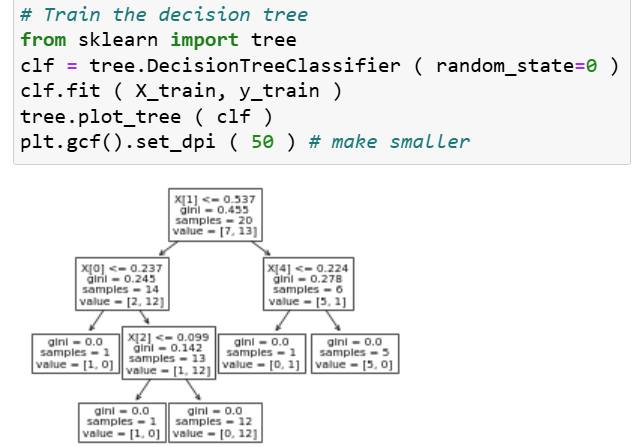

Es seien Daten $Q$ gegeben mit $(x,y)\in Q$, wobei $x\in \mathbb{R}^n$ Features sind und $y\in \{0,1\}$ Labels.

Es sei $p(Q)$ der Anteil der "$y=1$"-Labels in $Q$. Dann ist die **Gini-Impurity** definiert via $H(Q) = 2p(Q)(1-p(Q))$.

<span class="tinyfont">Der Algorithmus ist eine Modifikation des CART-Algorithmus: https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation;  
    siehe auch ID3, C4.5 und C5.0 für alternative Implementationen.</span> 

<div class="smallfont">
1. Für jedes Feature $j\in\{1,...,n\}$ und jeden möglichen Splitwert $t$, zerlege die Daten in Mengen $Q^\text{left}(j,t)$ und $Q^\text{right}(j,t)$, definiert via
\begin{align*}
Q^\text{left}(j,t) &= \{(x,y)\in Q\,|\,x_j \le t \} \\
Q^\text{right}(j,t) &= Q \setminus Q^\text{left}(j,t)
\end{align*}
</div>

<div class="smallfont">2. Die Qualität eines Splits $\theta = (j,t)$ wird bewertet durch eine Impurity-Funktion $H$ (z.B. Gini-Impurity oder Entropie):
\begin{align*}
\text{gemittelte Impurity nach dem Split: }G(Q,\theta) = \frac{N^\text{left}}{N} H \left( Q^\text{left}(\theta) \right) + \frac{N^\text{right}}{N} H \left( Q^\text{right}(\theta) \right)
\end{align*}
Hierbei ist $N=|Q|$ und $N^\text{left}=|Q^\text{left}(\theta)|$, $N^\text{right}=|Q^\text{right}(\theta)|$.
</div>

<div class="smallfont">
3. Wähle den Split $\theta^\ast$, der die niedrigste gemittelte Impurity $G(Q,\theta)$ erzeugt: $\theta^\ast = \text{argmin}_\theta G(Q,\theta)$.
</div>

<div class="smallfont">
4. Fahre rekursiv fort auf $Q^\text{left}(\theta^\ast)$ und $Q^\text{right}(\theta^\ast)$, bis eine geeignete Abbruchbedingung erreicht ist: "until max_depth is reached, $N<\text{min_samples}$ or $N=1$".</div>

### Wiederholung (Impurity-Funktionen bei der Klassifizierung):
Es seinen $p_1,...,p_k$ die Proportionen der Klassen (binäre Klassifikation: $k=2$) in einem Knoten des Baumes.

**Gini-Impurity** (`DecisionTreeClassifier(critierion="gini")`): $H( (p_1,...,p_k)) = \sum_{i=1}^k p_i (1-p_i) = 1 - \sum_{i=1}^k p_i^2$

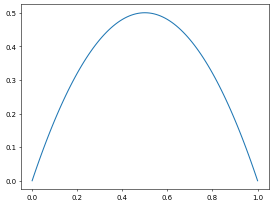

In [17]:
p = np.linspace(0,1,101)
plt.plot(p, 2*p*(1-p)) # binäre Klassifikation
plt.gcf().set_dpi(50);

**Entropy-Impurity ("log loss")** (`DecisionTreeClassifier(critierion="entropy")`): $H( (p_1,...,p_k)) = -\sum_{i=1}^k p_i \ln p_i$

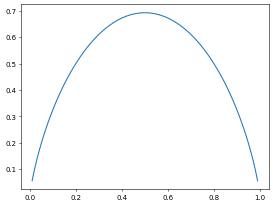

In [18]:
p = np.linspace(0.01,0.99,99)
plt.plot(p, -p*np.log(p)-(1-p)*np.log(1-p) )  # binär
plt.gcf().set_dpi(50);

<center>

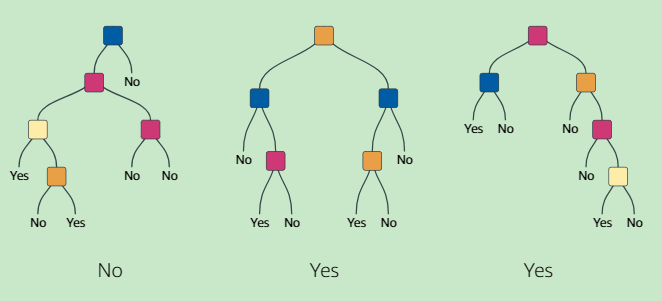
    
</center>

# <div style="color:blue;">1. Regressionsmetriken</div>
# <div>2. Random Forest</div>

### 1.1 Wiederholung: Der sklearn diabetes-Datensatz

In [3]:
# Der sklearn diabetes-Datensatz
from sklearn.datasets import load_diabetes
X = load_diabetes(as_frame=True)

# Daten extrahieren
X,y = X["data"], X["target"]
df = pd.concat([X,y],axis=1)

# .T zum transponieren (spiegeln)
# (hier verwendet, um alle Spalten zu sehen)
df.head().T


,0,1,2,3,4
age,0.038076,-0.001882,0.085299,-0.089063,0.005383
sex,0.050680,-0.044642,0.050680,-0.044642,-0.044642
bmi,0.061696,-0.051474,0.044451,-0.011595,-0.036385
bp,0.021872,-0.026328,-0.005670,-0.036656,0.021872
s1,-0.044223,-0.008449,-0.045599,0.012191,0.003935
s2,-0.034821,-0.019163,-0.034194,0.024991,0.015596
s3,-0.043401,0.074412,-0.032356,-0.036038,0.008142
s4,-0.002592,-0.039493,-0.002592,0.034309,-0.002592
s5,0.019907,-0.068332,0.002861,0.022688,-0.031988
s6,-0.017646,-0.092204,-0.025930,-0.009362,-0.046641


Features s1-s6 sind diverse Blutwerte:

| Spalte | Beschreibung |
|--------|--------------|
age | age in years
sex | sex
bmi | body mass index
bp | average blood pressure
s1 | tc, total serum cholesterol
s2 | ldl, low-density lipoproteins
s3 | hdl, high-density lipoproteins
s4 | tch, total cholesterol / HDL
s5 | ltg, possibly log of serum triglycerides level
s6 | glu, blood sugar level
target | a quantitative measure of disease progression one year after baseline

> Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples

<div class="tinyfont">https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset</div>

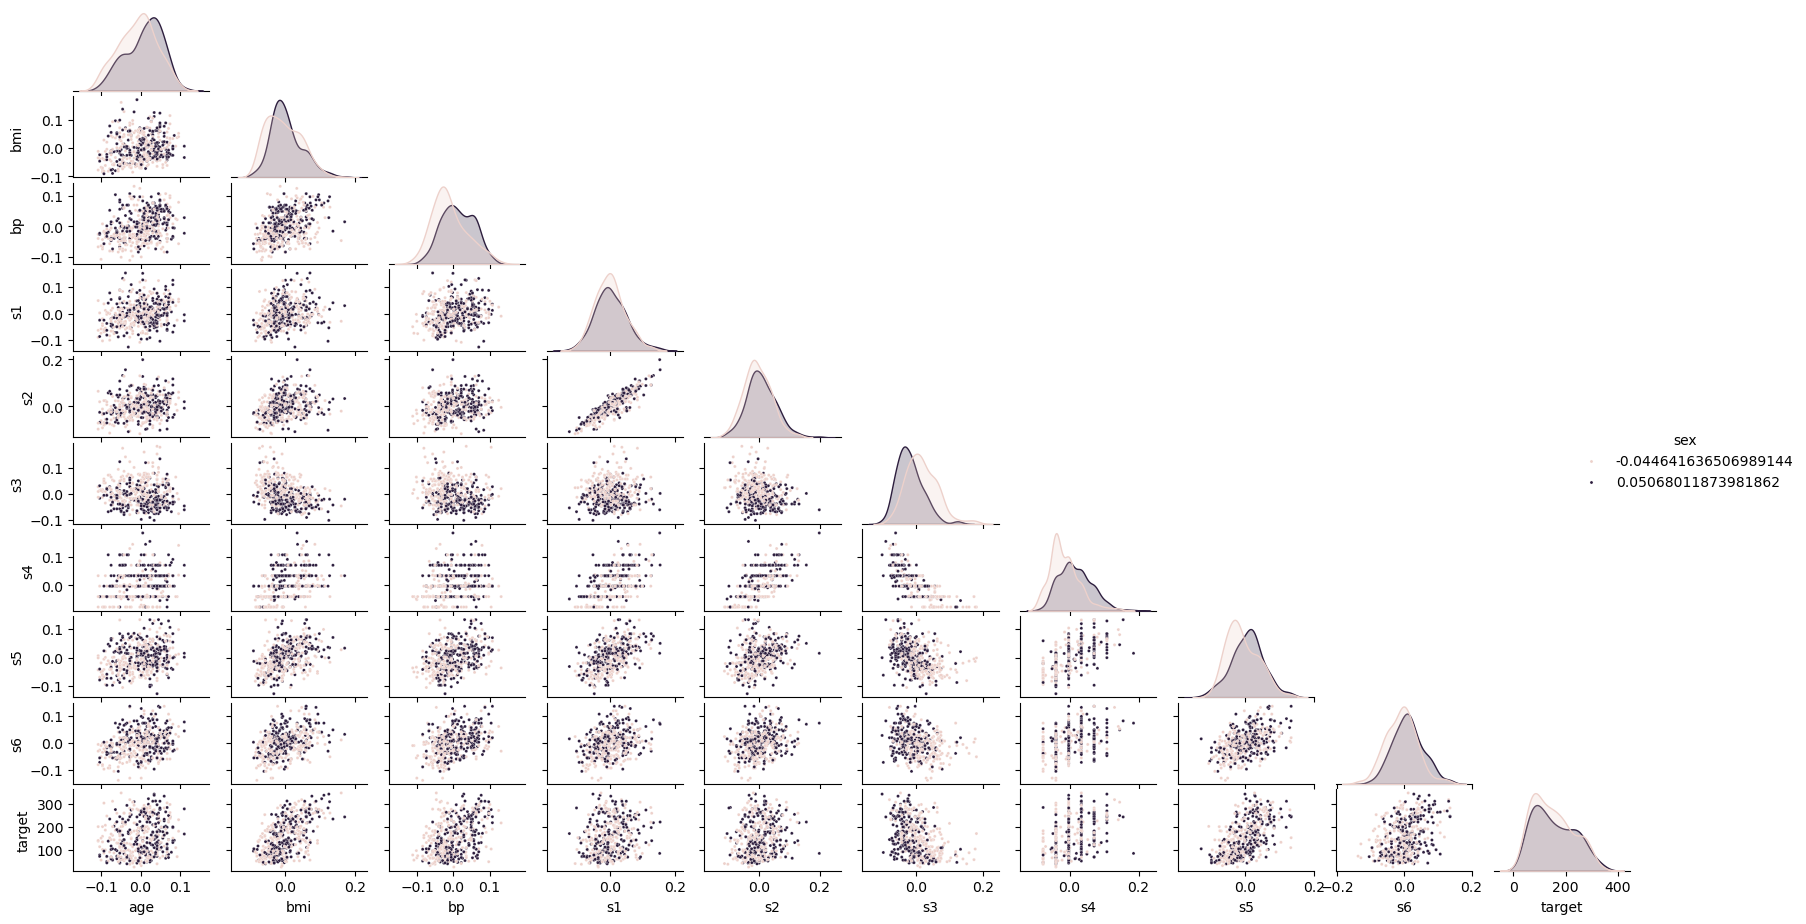

In [3]:
# Überblick verschaffen
sns.pairplot ( df, plot_kws={"s":5}, hue="sex", corner=True ) # corner=True entfernt die überflüssigen "gespiegelten" Plots
plt.gcf().set_size_inches(18, 9); plt.gcf().set_dpi(100);

### 1.2 Wiederholung: Entscheidungsbaum zum Training einer Regression

In [4]:
# Verzichte der Einfachheit halber auf einen
# zusätzlichen Testdatensatz
# (wir tun so, als hätten wir diesen bereits
# zur Seite gelegt)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
   train_test_split(X, y, random_state=42,
                    train_size=0.6, stratify=X["sex"])

len(X_train), len(X_val)


(265, 177)

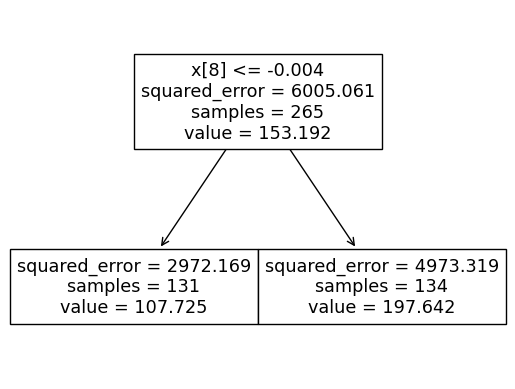

In [6]:
# Trainiere einen Entscheidungsbaum
# auf den Regressions-Task, die kontinuierliche
# Zielgröße "target" vorherzusagen
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor( max_depth=1 )
reg.fit ( X_train, y_train )

from sklearn.tree import plot_tree
plot_tree ( reg );


### 1.3 Wiederholung: Algorithmus des Entscheidungsbaums für eine Regression

...

<div class="smallfont">2. Die Qualität eines Splits $\theta = (j,t)$ wird bewertet durch eine Impurity-Funktion $H$ (<span style="color:orange">bei einer Regression: <b>H=squared_error</b></span>):
\begin{align*}
\text{gemittelte Impurity nach dem Split: }G(Q,\theta) = \frac{N^\text{left}}{N} H \left( Q^\text{left}(\theta) \right) + \frac{N^\text{right}}{N} H \left( Q^\text{right}(\theta) \right)
\end{align*}
Hierbei ist $N=|Q|$ und $N^\text{left}=|Q^\text{left}(\theta)|$, $N^\text{right}=|Q^\text{right}(\theta)|$.
</div>

<div class="smallfont">
3. Wähle den Split $\theta^\ast$, der die niedrigste Impurity $G(Q,\theta)$ (gewichtetes Mittel über die Impurities der beiden erzeugten Teilmengen) erzeugt: $\theta^\ast = \text{argmin}_\theta G(Q,\theta)$.
</div>

...

<div class="alert alert-block alert-info"><b>Impurity-Funktion "squared_error" für die Regression:</b> Wir betrachten wie oben eine Teilmenge $Q$ der Daten.  

&nbsp;
1. Berechne den Mittelwert der Zielgröße $\overline{y}_Q = \frac{1}{|Q|}\sum_{(x,y)\in Q}y$
2. Die Impurity ist die gemittelte quadratische Abweichung vom Mittelwert (=Varianz*): $H(Q) = \frac{1}{|Q|}\sum_{(x,y)\in Q}(y-\overline{y}_Q)^2$

</div>
<div class="smallfont">* ... bis auf Verwendung des Normierungsfaktors 1/|Q| statt 1/(|Q|-1), der üblicherweise für die empirische Varianz verwendet wird.</div>

### 1.4 Wiederholung: Predictions für verschiedene Baumtiefen (auf den Trainingsdaten)

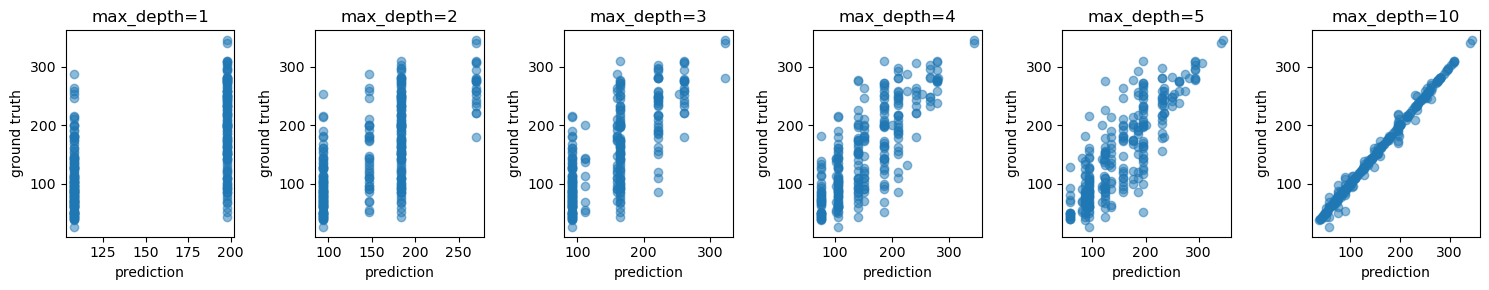

In [121]:
fig, axes = plt.subplots ( figsize=(15,3), ncols=6 )
for max_depth, ax in zip ( [1,2,3,4,5,10], axes ):
    # train
    reg = DecisionTreeRegressor( max_depth=max_depth, random_state=0 )
    reg.fit ( X_train, y_train )
    
    # plot the predictions on the training set
    ax.scatter ( reg.predict(X_train), y_train, alpha=0.5 )
    ax.set_xlabel ( "prediction" )
    ax.set_ylabel ( "ground truth" )
    ax.set_title ( "max_depth="+str(max_depth) )
plt.tight_layout()


<div class="alert alert-block alert-warning"><b>Frage:</b> Wie messen wir die Qualität der Vorhersage?</div>

### 1.5 Metriken zum Vergleich der "Ground Truth" `y` und der Vorhersage `pred`

**Mean Squared Error:**

$$MSE(y,pred) = \frac{1}{n}\sum_{i=1}^n (y_i - pred_i)^2$$

**Root Mean Squared Error:**

$$RMSE(y,pred) = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - pred_i)^2}$$

In [6]:
# mit squared=False wird aus dem MSE ein RMSE
from sklearn.metrics import mean_squared_error

# trainiere das Modell
reg = DecisionTreeRegressor( max_depth=5,
                             random_state=0 )
reg.fit ( X_train, y_train )
pred_train = reg.predict ( X_train )

# berechne die Metrik
mean_squared_error ( y_train, pred_train ), \
   ((y_train-pred_train)**2).mean()


(1791.735965227891, 1791.735965227891)

RMSE ist intuitiv, ist aber nur interpretierbar im Vergleich mit der Werteskala von `target`:  
> "`target` nimmt Werte zwischen 100 und 300 an,  
$\sqrt{1791}\approx 42$ ist in Relation hierzu groß."

In der **R²-Metrik** wird daher normiert durch die "naive" Vorhersage, in der einfach immer der Mittelwert $\overline{y}$ vorhergesagt wird:

\begin{align*}
R²(y,pred) &= 1 - \frac{ MSE(y,pred) }{ MSE(y,\overline{y}) }  \\
& \\
&= 1 - \frac{ \sum_{i=1}^n (y_i - pred_i)^2 }{ \sum_{i=1}^n (y_i - \overline{y})^2 }
\end{align*}

In [7]:
from sklearn.metrics import r2_score

# trainiere das Modell
reg = DecisionTreeRegressor( max_depth=5,
                             random_state=0 )
reg.fit ( X_train, y_train )
pred_train = reg.predict(X_train)

# kürze ab ([2]*3 = [2,2,2])
mse    = mean_squared_error
y_quer = [y_train.mean()]*len(y_train)

# berechne die Metrik
r2_score ( y_train, pred_train ), \
   1-mse(y_train, pred_train)/mse(y_train,y_quer)


(0.7016290187867291, 0.701629018786729)

**Interpretation:**
- `R²=1` ist ein perfekter Fit.  
- Bei `R²=0` ist der Fit genauso schlecht wie bei der konstanten Vorhersage $\overline{y}$.

&nbsp;<br>
<div class="smallfont">Mit etwas mehr Aufwand kann man R² als "explained variance ratio" interpretieren: Wie viel Varianz der Daten wird durch das Modell erklärt?</div>

### 1.6 Metriken im Beispiel "verschiedene Baumtiefen"

Auf den Trainingsdaten:

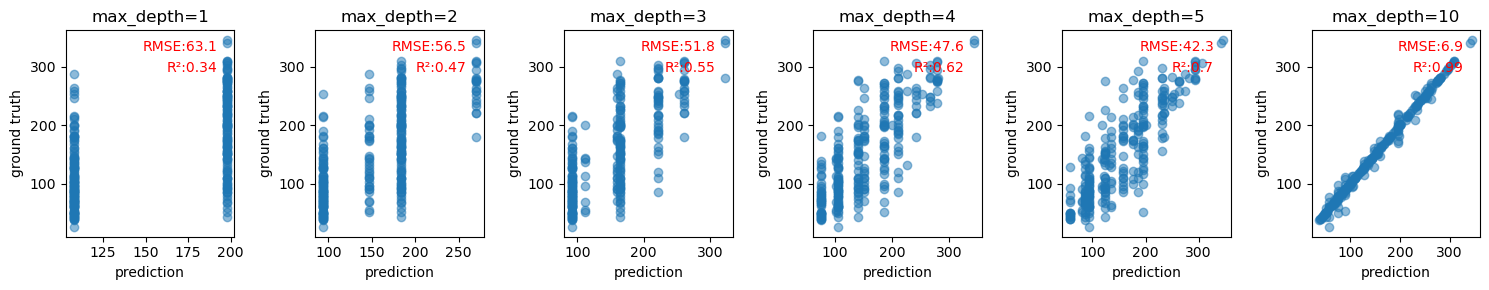

In [137]:
fig, axes = plt.subplots ( figsize=(15,3), ncols=6 )
for max_depth, ax in zip ( [1,2,3,4,5,10], axes ):
    reg = DecisionTreeRegressor( max_depth=max_depth, random_state=0 )
    reg.fit ( X_train, y_train )
    ax.scatter ( reg.predict(X_train), y_train, alpha=0.5 )
    ax.set_xlabel ( "prediction" )
    ax.set_ylabel ( "ground truth" )
    ax.set_title ( "max_depth="+str(max_depth) )
    ax.text ( s="RMSE:"+str(round( mean_squared_error(y_train,reg.predict(X_train), squared=False),1 )),
              x=0.9, y=0.9, transform=ax.transAxes, color="red", ha="right" )
    ax.text ( s="R²:"+str(round( r2_score(y_train,reg.predict(X_train)),2)),
              x=0.9, y=0.8, transform=ax.transAxes, color="red", ha="right" )
plt.tight_layout()


Auf den Validierungsdaten: **Overfit!**

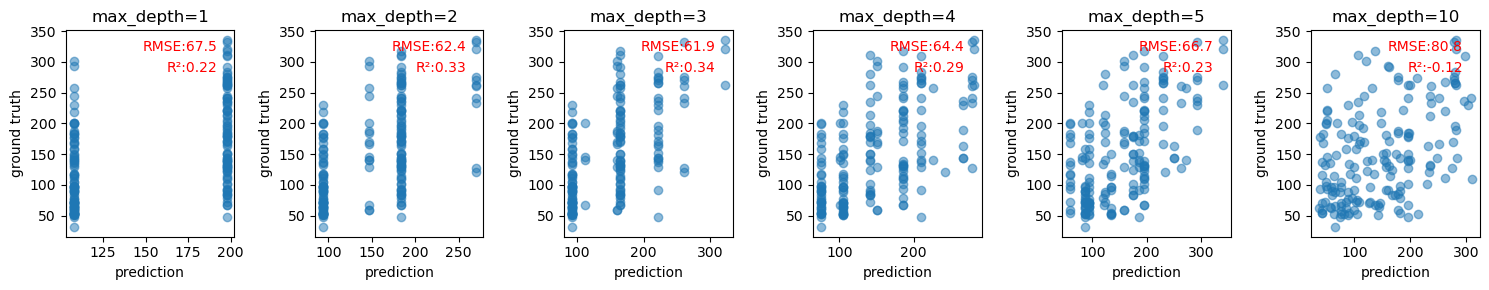

In [135]:
fig, axes = plt.subplots ( figsize=(15,3), ncols=6 )
for max_depth, ax in zip ( [1,2,3,4,5,10], axes ):
    reg = DecisionTreeRegressor( max_depth=max_depth, random_state=0 )
    reg.fit ( X_train, y_train )
    ax.scatter ( reg.predict(X_val), y_val, alpha=0.5 )
    ax.set_xlabel ( "prediction" )
    ax.set_ylabel ( "ground truth" )
    ax.set_title ( "max_depth="+str(max_depth) )
    ax.text ( s="RMSE:"+str(round( mean_squared_error(y_val,reg.predict(X_val), squared=False),1 )),
              x=0.9, y=0.9, transform=ax.transAxes, color="red", ha="right" )
    ax.text ( s="R²:"+str(round( r2_score(y_val,reg.predict(X_val)),2)),
              x=0.9, y=0.8, transform=ax.transAxes, color="red", ha="right" )
plt.tight_layout()


**Validation curve**: Visualisierung der gewählten Metrik ("Score des Modells") auf Trainings- und Validierungsdaten  
unter Veränderung eines Hyperparameters

In [46]:
# Wir variieren den Hyperparameter max_depth und
# notieren jeweils für Train/Val-Daten den R²-Score
r2_train = dict()
r2_val   = dict()

for max_depth in range(1,10):
    # Training + Vorhersage
    reg = DecisionTreeRegressor( max_depth=max_depth,
                                 random_state=0 )
    reg.fit ( X_train, y_train )
    pred_train = reg.predict(X_train)
    pred_val   = reg.predict(X_val)
    
    # Berechnung der R²-Metriken
    r2_train[max_depth] = r2_score(y_train,pred_train)
    r2_val  [max_depth] = r2_score(y_val,  pred_val)

r2_val


{1: 0.21595200072016152,
 2: 0.3293006176660467,
 3: 0.34126579618716957,
 4: 0.28647384463156433,
 5: 0.23357563788504443,
 6: 0.1687399690916409,
 7: 0.05157080907429035,
 8: -0.015034374266567285,
 9: -0.14687857286137906}

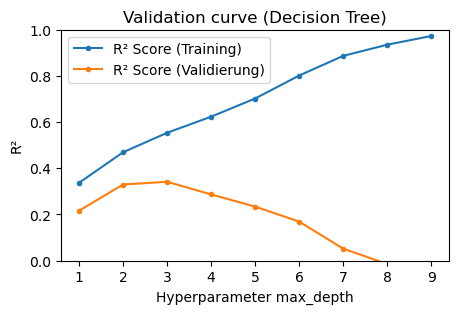

In [48]:
# Visualisierung

fig, ax = plt.subplots ( figsize=(5,3) )
ax.plot ( r2_train.keys(), r2_train.values(),
          marker=".", label="R² Score (Training)" )
ax.plot ( r2_val.keys(), r2_val.values(),
          marker=".", label="R² Score (Validierung)" )
ax.set_title ( "Validation curve (Decision Tree)")
ax.set_xlabel("Hyperparameter max_depth")
ax.set_ylabel("R²")
ax.set_ylim(0,1)
ax.legend();


### 1.7 "Stufeneffekt" bei der Vorhersage ($2^d$ mögliche Vorhersagewerte bei Tiefe $d$)

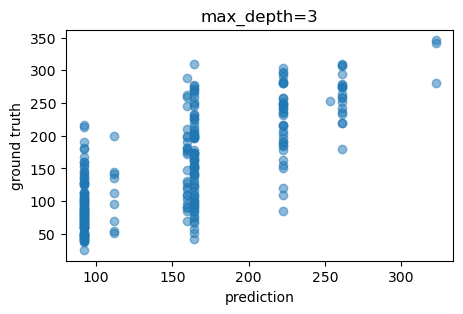

In [268]:
# Fit und Predict
reg = DecisionTreeRegressor( max_depth=3,
                             random_state=0 )
reg.fit ( X_train, y_train )
pred_train = reg.predict ( X_train )

# Visualisierung des Stufeneffekts
fig, ax = plt.subplots ( figsize=(5,3) )
ax.scatter (pred_train, y_train, alpha=0.5)
ax.set_xlabel ( "prediction" )
ax.set_ylabel ( "ground truth" )
ax.set_title ( "max_depth=3" );


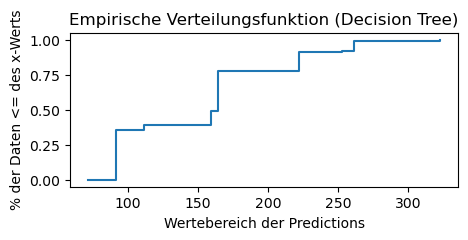

In [269]:
# "empirical cumulated density function"
def ecdf(a):
    # Berechne die Sprungstellen und -höhen
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    cusum = cusum/cusum[-1]
    
    # zusätzlicher Punkt, um den ersten Sprung zu sehen
    x = np.insert(x,0,x[0]-(x[1]-x[0]))
    cusum = np.insert(cusum,0,0.0)
    return x, cusum

fig, ax = plt.subplots ( figsize=(5,2) )
ax.plot ( *ecdf(pred_train), drawstyle='steps-post' )
ax.set_xlabel ( "Wertebereich der Predictions" )
ax.set_ylabel ( "% der Daten <= des x-Werts" )
ax.set_title ( "Empirische Verteilungsfunktion (Decision Tree)" );


<center>

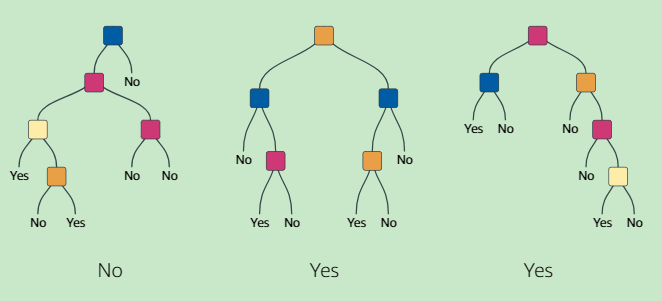
    
</center>

# <div>1. Regressionsmetriken</div>
# <div style="color:blue;">2. Random Forest</div>

### 2.1 Random Forest: Mittelung über viele Bäume

**Idee:** Wenn über viele Bäume gemittelt wird, gibt es mehr mögliche Vorhersagewerte. Der Stufeneffekt verschwindet.

In [8]:
# Ein Entscheidungsbaum
reg = DecisionTreeRegressor( max_depth=3,
                             random_state=0 )
reg.fit ( X_train, y_train )
pred_val = reg.predict(X_val)

# R²-Metrik auf dem Validierungsdatensatz
print ( r2_score(y_val,  pred_val) )


0.34126579618716957


In [9]:
# Viele Bäume
N = 10

for repetition in range(N):
    reg = DecisionTreeRegressor(max_depth=3,
                                random_state=repetition)
    reg.fit ( X_train, y_train )
    pred_val = reg.predict(X_val)

    # Ergebnis
    print ( r2_score(y_val,  pred_val) )
    

0.34126579618716957
0.34126579618716957
0.34126579618716957
0.34126579618716957
0.34126579618716957
0.34126579618716957
0.34126579618716957
0.34126579618716957
0.34126579618716957
0.34126579618716957


<div class="alert alert-block alert-warning"><b>Problem:</b> Wir erhalten 10 identische Bäume. Wie bekommen wir unterschiedliche Bäume?</div>

**Ideen:** Wähle fürs Training nur eine zufällige Teilmenge, und lasse bei jedem Split nur zufällig gewählte Möglichkeiten zu.

In [10]:
# Zufällige Teilmenge: Verwende den Index,
# um sicherzustellen, dass die gleichen Zeilen
# von X_train, y_train ausgewählt werden
idx = X_train.sample(frac=1.0, replace=True).index
X_train_thistree = X_train.loc[idx,:]
y_train_thistree = y_train.loc[idx]

# Wegen Ziehen mit Zurücklegen:
# Indizes werden oft doppelt vorkommen.
# Wegen Beschränkung auf n=len(X_train),
# (äquiv. zu frac=1.0) werden nicht alle Daten
# in diesem Training verwendet.
# (ca. 1/3 der Daten wird nicht verwendet)
idx.value_counts()


106    5
74     4
9      4
211    4
319    4
      ..
88     1
227    1
226    1
225    1
1      1
Length: 174, dtype: int64

In [12]:
# Verwende den Hyperparameter "max_features",
# damit bei jedem Split nur eine zufällige Auswahl
# von Features berücksichtigt werden
reg = DecisionTreeRegressor( max_depth=3,
                             max_features=5 )
reg.fit ( X_train_thistree, y_train_thistree );


 Zusammengesetzt:

In [9]:
# Viele **verschiedene** Bäume
N = 10

for repetition in range(N):
    idx = X_train.sample(frac=1.0, replace=True).index
    X_train_thistree = X_train.loc[idx,:]
    y_train_thistree = y_train.loc[idx]

    reg = DecisionTreeRegressor( max_depth=3,
                                 max_features=5 )
    reg.fit ( X_train_thistree, y_train_thistree )
    pred_val = reg.predict(X_val)

    # Ergebnis
    print ( r2_score(y_val, pred_val) )
    

0.26902806409421776
0.2420580462921217
0.2075867123096814
0.2083003122264151
0.31269168269456205
0.27838535734312786
0.1277150907153385
0.14793872293260324
0.13026957646105808
0.21159433287973584


Es fehlt noch die **Mittelung der Vorhersagen**.

In [18]:
# Wir sammeln hierfür die Vorhersagen:
pred_val = []
# ...
pred_val.append (reg.predict(X_val[:3]))
# ...
pred_val.append (reg.predict(X_val[:3]))
pred_val

[array([194.08571429, 144.875     ,  89.85057471]),
 array([194.08571429, 144.875     ,  89.85057471])]

**Mittelung der Vorhersagen:**

In [22]:
# Viele **verschiedene** Bäume (N=10)
pred_val = []

for repetition in range(N):
    idx = X_train.sample(frac=1.0, replace=True).index
    X_train_thistree = X_train.loc[idx,:]
    y_train_thistree = y_train.loc[idx]

    reg = DecisionTreeRegressor( max_depth=3,
                                 max_features=5 )
    reg.fit ( X_train_thistree, y_train_thistree )
    pred_val.append ( reg.predict(X_val) )

pd.DataFrame(pred_val)
# Bedeutung der Zeilen/Spalten?


,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,148.737705,148.737705,93.606742,93.606742,246.746032,246.746032,148.737705,93.606742,93.606742,148.737705,...,246.746032,131.206897,148.737705,246.746032,131.206897,93.606742,93.606742,131.206897,93.606742,93.606742
1,141.250000,126.476190,73.333333,73.333333,200.770833,238.687500,141.250000,105.548387,105.548387,141.250000,...,200.770833,141.250000,126.476190,268.875000,105.548387,105.548387,73.333333,141.250000,73.333333,73.333333
2,144.775510,144.775510,65.157895,65.157895,192.158730,192.158730,109.448718,109.448718,109.448718,144.775510,...,242.842105,109.448718,237.500000,192.158730,109.448718,109.448718,65.157895,192.158730,65.157895,65.157895
3,233.877551,106.394737,92.692308,92.692308,233.877551,233.877551,160.471698,92.692308,92.692308,189.785714,...,233.877551,99.357143,143.900000,233.877551,106.394737,106.394737,92.692308,160.471698,92.692308,92.692308
4,123.754902,123.754902,123.754902,89.634146,161.333333,256.533333,162.852941,123.754902,89.634146,89.634146,...,161.333333,123.754902,123.754902,162.852941,123.754902,162.852941,123.754902,161.333333,123.754902,89.634146
5,148.462963,148.462963,98.735849,148.462963,210.724638,210.724638,148.462963,98.735849,62.750000,148.462963,...,210.724638,98.735849,148.462963,210.724638,98.735849,98.735849,98.735849,98.735849,98.735849,98.735849
6,207.083333,207.083333,90.059406,90.059406,172.964286,207.083333,172.964286,90.059406,90.059406,207.083333,...,125.416667,172.964286,207.083333,172.964286,90.059406,90.059406,90.059406,172.964286,90.059406,90.059406
7,205.574257,149.444444,84.507042,84.507042,205.574257,205.574257,205.574257,84.507042,93.043478,205.574257,...,205.574257,205.574257,84.507042,205.574257,163.181818,163.181818,84.507042,93.166667,84.507042,84.507042
8,167.320988,101.655738,70.157895,101.655738,167.320988,225.583333,167.320988,100.041667,100.041667,167.320988,...,167.320988,167.320988,101.655738,225.583333,138.185185,138.185185,70.157895,167.320988,70.157895,101.655738
9,193.538462,136.218750,77.606061,77.606061,226.641026,226.641026,124.590164,77.606061,124.590164,193.538462,...,226.641026,124.590164,136.218750,186.133333,124.590164,124.590164,77.606061,186.133333,77.606061,77.606061


In [23]:
# Mittelung der Vorhersagen liefert
# "gemittelte Predictions" für die 177 Patienten
pd.DataFrame(pred_val).mean(axis=0)

0      171.437567
1      139.300427
2       86.961143
3       91.671563
4      201.811167
          ...    
172    119.260395
173     86.961143
174    150.474178
175     86.961143
176     86.698852
Length: 177, dtype: float64

<div class="alert alert-block alert-warning"><b>Frage</b>: Was können wir noch aus dem DataFrame lernen?</div>

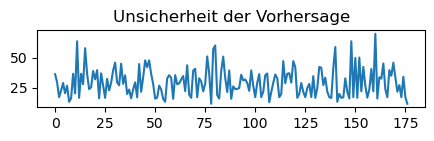

In [24]:
pd.DataFrame(pred_val).std(axis=0).plot(figsize=(5,1),
   title="Unsicherheit der Vorhersage");

**Erinnerung:** Beim (einzelnen) Baum haben wir beobachtet, dass nur 2^Baumtiefe (hier 2^3) Werte angenommen werden.

**Idee:** Durch die Mittelung über viele Bäume sollte der Stufeneffekt verschwinden.

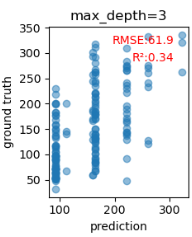

In [25]:
# In der Tat: Wir haben nach Mittelung viel mehr
#             Werte (138 statt 2^3)
pred_val_mean = pd.DataFrame(pred_val).mean(axis=0)
pred_val_mean.nunique()

# pandas.Series.nunique() liefert die Zahl der
# eindeutigen Elemente zurück; Alternative z.B.
# len ( pred_val_mean.value_counts() )


138

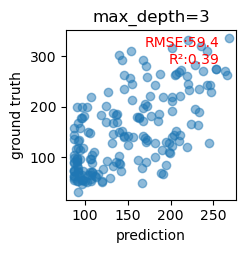

In [37]:
fig, ax = plt.subplots ( figsize=(2.2,2.2) )
ax.scatter ( pred_val_mean, y_val, alpha=0.5 )
ax.set_xlabel("prediction"); ax.set_ylabel("ground truth")
ax.set_title("max_depth=3")
ax.text ( s="RMSE:"+str(round( mean_squared_error(y_val,pred_val_mean, squared=False),1 )),
          x=0.9, y=0.9, transform=ax.transAxes, color="red", ha="right" )
ax.text ( s="R²:"+str(round( r2_score(y_val,pred_val_mean),2)),
          x=0.9, y=0.8, transform=ax.transAxes, color="red", ha="right" );

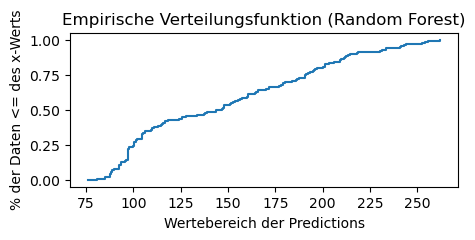

In [270]:
# "empirical cumulated density function"
def ecdf(a):
    # Berechne die Sprungstellen und -höhen
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    cusum = cusum/cusum[-1]
    
    # zusätzlicher Punkt, um den ersten Sprung zu sehen
    x = np.insert(x,0,x[0]-(x[1]-x[0]))
    cusum = np.insert(cusum,0,0.0)
    return x, cusum

fig, ax = plt.subplots ( figsize=(5,2) )
ax.plot ( *ecdf(pred_val_mean), drawstyle='steps-post' )
ax.set_xlabel ( "Wertebereich der Predictions" )
ax.set_ylabel ( "% der Daten <= des x-Werts" )
ax.set_title ( "Empirische Verteilungsfunktion (Random Forest)" );


**Frage:** Wie verändert sich die Performance durch die Mittelung?

In [39]:
# Funktionalität, wie zuvor erklärt:
# - Trainiere N Bäume auf zufälligen Teilmengen der Trainingsdaten.
# - Schränke die Split-Möglichkeiten zufällig ein via dem Parameter max_features.
# - Berechne (jeweils für alle N Bäume) die Predictions auf Trainings- und Validierungsdaten.
# - Gebe nur den Mittelwert (je Patient über alle N Bäume) zurück.

def random_forest_predictions ( X_train, y_train, X_val, N=10, max_depth=3, max_features=5 ):
    pred_train = []
    pred_val   = []

    for repetition in range(N):
        idx = X_train.sample(frac=1.0, replace=True).index
        X_train_thistree = X_train.loc[idx,:]
        y_train_thistree = y_train.loc[idx]

        reg = DecisionTreeRegressor( max_depth=max_depth, max_features=max_features )
        reg.fit ( X_train_thistree, y_train_thistree )
        
        pred_train.append ( reg.predict(X_train) )   # * hier vereinfachen wir; besser wäre X_train_thistree (-> OOB-Metrik)
        pred_val.append   ( reg.predict(X_val)   )
    
    return pd.DataFrame ( pred_train ).mean(axis=0), pd.DataFrame ( pred_val ).mean(axis=0)


Veränderung der **Validation curves** durch die Mittelung über viele Bäume:

In [43]:
r2_train = dict()
r2_val   = dict()

for max_depth in range(1,10):
    # Berechnung der Predictions von N=100 Bäumen;
    # für jeden Patient wird der Mittelwert
    # über die N Predictions berechnet.
    pred_train, pred_val = random_forest_predictions(
        X_train, y_train, X_val, N=100,
        max_depth=max_depth )
    
    # Berechnung der R²-Metriken
    r2_train[max_depth] = r2_score(y_train,pred_train)
    r2_val  [max_depth] = r2_score(y_val,  pred_val)

r2_val


{1: 0.319478022671861,
 2: 0.3920850014478231,
 3: 0.4133268295251711,
 4: 0.4059935969462999,
 5: 0.39761491663734405,
 6: 0.4103043064626739,
 7: 0.39151450353507633,
 8: 0.3951559010565481,
 9: 0.3883251420915742}

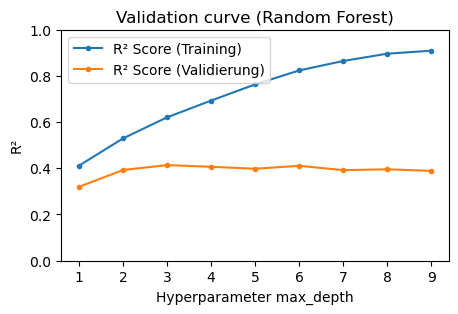

In [45]:
fig, ax = plt.subplots ( figsize=(5,3) )
ax.plot ( r2_train.keys(), r2_train.values(),
          marker=".", label="R² Score (Training)" )
ax.plot ( r2_val.keys(), r2_val.values(),
          marker=".", label="R² Score (Validierung)" )
ax.set_title ( "Validation curve (Random Forest)")
ax.set_xlabel("Hyperparameter max_depth")
ax.set_ylabel("R²")
ax.set_ylim(0,1)
ax.legend( loc="upper left" );


In [ ]:
#         pred_train.append ( pd.Series(reg.predict(X_train), index=X_train.index) )
        pred_train.append ( pd.Series (reg.predict(X_train_thistree.drop_duplicates()),
                                       index=X_train_thistree.drop_duplicates().index) )
        pred_val.append ( pd.Series (reg.predict(X_val), index=X_val.index) )

**Zusammenfassung**: Ein **Random Forest** entsteht durch die Mittelung der Predictions über viele Entscheidungsbäume.

<div class="smallfont">Damit nicht alle Bäume identisch sind, wird jeder Baum auf einer zufällig gewählten Teilmenge der Trainingsdaten trainiert (typischerweise "Ziehen mit Zurücklegen", bis die ursprüngliche Trainingsdatengröße erreicht ist). Zusätzlich werden die Split-Möglichkeiten zufällig eingeschränkt.</div>

Durch die Mittelung über viele Bäume (rechts) ist der Stufeneffekt in der Regressionsvorhersage verschwunden.

| 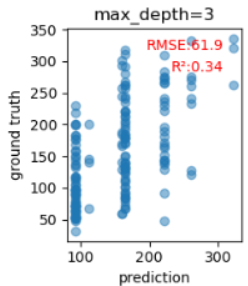 | 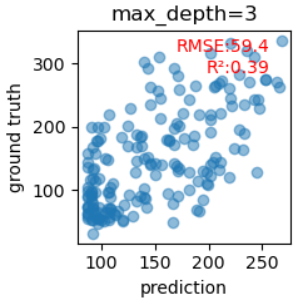 |
|   -|- |

Die Validation Curves zeigen, dass die Performance **absolut** besser geworden ist, aber auch **robuster** bzgl. Overfitting:

| 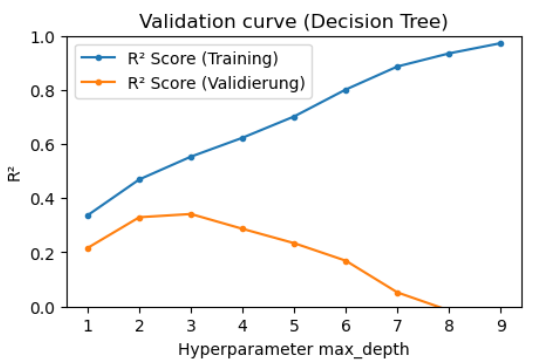 | 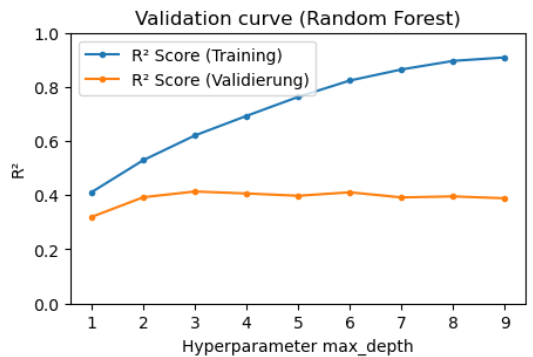 |
|   -|- |

**Zusatznutzen:** Verwendung der Standardabweichung der Predictions als "Unsicherheitsmaß".

<div class="smallfont"><b>Zusatz-Zusatznutzen:</b> Verwendung der in Baum k beim Training nicht verwendeten Daten als zusätzliche Validierungsdaten ("OOB-Metrik")</div>

<center>

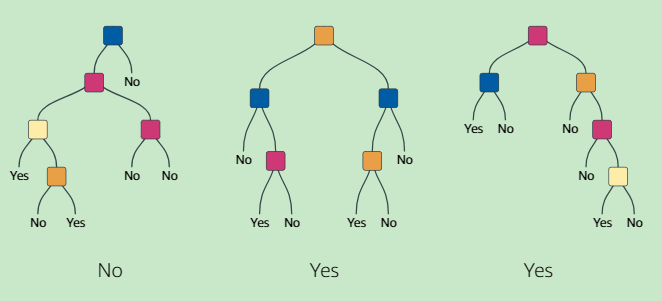
    
</center>

https://mlu-explain.github.io/random-forest/

# <div style="color:gray;">1. Regressionsmetriken</div>
# <div style="color:gray;">2. Random Forest</div>

# Vielen Dank für Ihre Aufmerksamkeit!